In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from preprocessing_v4 import data_preprocessing
from preprocessing_v4 import draw_graph

pd.set_option('display.max_columns', 60)
pd.set_option('display.max_rows', 60)
pd.set_option('mode.chained_assignment',  None)

plt.rc('font',family='malgun gothic')

# 국가교통 데이터 오픈마켓
bus_info_data_by_day = pd.read_csv('./data/대전시_버스_일일_정보_데이터.csv', sep = "|") # 대전시 버스 일일 정보 데이터
bus_speed_data = pd.read_csv('./data/대전시_버스_통행_속도_데이터.csv', sep = "|") # 대전시 버스 통행 속도 데이터
bus_route_statistic_data = pd.read_csv('./data/대전시_버스_노선_운행_통계_데이터.csv', sep = "|") # 대전시 버스 노선 운행 통계 데이터
bus_card_data = pd.read_csv('./data/대전시_버스_교통카드거래_이력_데이터.csv', sep = "|") # 대전시 버스 카드 거래 이력 데이터
speed_comparison_data = pd.read_csv('./data/대전시_버스전용차로_승용차구간_속도비교_데이터.csv', sep = "|") # 대전시 버스전용차로 승용차구간 속도비교 데이터

bus_info_data_by_day.drop(labels = ['ETL_TYPE','ETL_DATE'], axis =  1, inplace = True)
bus_speed_data.drop(labels = ['ETL_TYPE','ETL_DATE'], axis =  1, inplace = True)
bus_route_statistic_data.drop(labels = ['ETL_TYPE','ETL_DATE'], axis =  1, inplace = True)
bus_card_data.drop(labels = ['ETL_TYPE','ETL_DATE'], axis =  1, inplace = True)

# 대전 교통 빅데이터 플랫폼
route_curve = pd.read_csv('./data/route_curve.csv', encoding = 'cp949')
route_curve = route_curve.iloc[:,:5]

# 공공데이터포털
getrouteinfoall = pd.read_csv('./data/getRouteInfoAll.csv', encoding = 'cp949', index_col = 0) # 전체 노선 기본정보 조회
getstationbyrouteall = pd.read_csv('./data/getStationByRouteAll.csv', encoding = 'cp949', index_col = 0) # 전체노선별경유정류소 정보 조회

# 정류장 데이터
bus_sttn = pd.read_csv('./data/bus_sttn.csv')

# 스마트카드 데이터
smart_card_data = pd.read_csv('./data/smart_card_data.csv')

In [2]:
smart_card_data

,SERIAL_NO,CARD_NO,GETON_YMD,GETON_TM,TRANSACTION_ID,TR_MEANS_TYPE,TRANSF_CNT,BUS_ROUTE_ID,BUS_CO_ID,BUS_CAR_ID,USR_TYPE,DRVN_START_YMD,DRVN_START_TM,GETON_BUS_STTN_ID,GETOFF_YMD,GETOFF_TM,GETOFF_BUS_STTN_ID,YSR_CNT,GETON_PAY,GETOFF_PAY,DRVR_ID,GETON_CALC_YMD,GETOFF_CALC_YMD,ETL_TYPE,ETL_DATE
0,465526,541463722,20220401,81706,28,680,0,30300052,130010006,130752056,1,20220401,74957,8002432,20220401,083041,8001526,1,1250,0,,20220401,20220401,603,2022/04/12 07:02:59
1,465534,540104832,20220401,92542,17,675,0,30300083,130010001,130759426,1,20220401,61224,8001279,20220401,093729,8001538,1,1250,0,,20220401,20220401,603,2022/04/12 07:02:59
2,458075,608695670,20220401,191253,29,673,1,30300003,130510004,130751003,1,20220401,54238,8001777,20220401,192142,8007023,1,0,0,,20220401,20220401,603,2022/04/12 07:02:59
3,459772,741520439,20220401,73215,1,676,0,30300043,130010015,130759609,1,20220401,65354,8001428,20220401,075254,8002717,1,1250,0,,20220401,20220401,603,2022/04/12 07:02:59
4,459780,759623940,20220401,191041,1,676,0,30300071,130010009,130759147,1,20220401,131535,8001990,20220401,191539,8001464,1,1250,0,,20220401,20220401,603,2022/04/12 07:02:59
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10261501,32500,767327505,20220428,193507,27,676,0,30300037,130010006,130752011,1,20220428,190342,8006001,20220428,194956,8002235,1,1250,0,,20220428,20220428,603,2022/05/09 07:00:13
10261502,32508,661044511,20220428,141425,14,676,0,30300037,130010006,130752024,1,20220428,131226,8001574,20220428,141729,8002558,1,1250,0,,20220428,20220428,603,2022/05/09 07:00:13
10261503,32921,742104965,20220428,184937,7,676,0,30300071,130010009,130759186,1,20220428,131607,8002083,20220428,190736,8001078,1,1250,0,,20220428,20220428,603,2022/05/09 07:00:13
10261504,32929,660749042,20220428,180132,4,676,0,30300043,130010015,130759608,1,20220428,170314,8001748,20220428,180730,8001789,1,1250,0,,20220428,20220428,603,2022/05/09 07:00:13


In [2]:
def smart_card_preprocessing(exdata): # 스마트카드 데이터 전처리
    exdata = exdata[exdata['GETOFF_BUS_STTN_ID']!='~      '] # 하차 태그 없는 데이터 제거
    exdata['GETON_TM'] = exdata['GETON_TM'].apply(lambda x: str(x).zfill(6)) # GETON_TM 컬럼 날짜형식으로 변환하기 위해 자릿수 맞춰주기
    
    # datetime 형식으로 변환 및 새로운 column 생성
    exdata['GETON_DATETIME'] = pd.to_datetime(exdata['GETON_YMD'].astype(str) + exdata['GETON_TM'].astype(str), format = '%Y%m%d%H%M%S')
    exdata['GETOFF_DATETIME'] = pd.to_datetime(exdata['GETOFF_YMD'].astype(str) + exdata['GETOFF_TM'].astype(str), format = '%Y%m%d%H%M%S', errors = 'coerce')
    exdata['DAY'] = exdata['GETON_DATETIME'].dt.day
    exdata['WEEKDAY'] = exdata['GETON_DATETIME'].dt.weekday
    
    # 여러명이 탄 경우 제거
    exdata = exdata[exdata['YSR_CNT']==1]
    
    # 평일만 추출
    weekday_values = [0, 1, 2, 3, 4]
    exdata = exdata[exdata['WEEKDAY'].isin(weekday_values)]
    
    # 지선, 간선 버스만 필터링
    exdata = exdata[exdata['TR_MEANS_TYPE'].isin([676, 675])]
    
    # 4/15일 수치 이상 제거
    exdata = exdata[exdata['DAY']!=15]
    
    # 환승한 경우 제거
    transf_counts = [3, 2, 1]

    for count in transf_counts:
        card_nos_to_remove = exdata[exdata['TRANSF_CNT'] == count]['CARD_NO']
        exdata = exdata[~exdata['CARD_NO'].isin(card_nos_to_remove)]
        
    # 도시 노선만 사용하기 위해
    values_to_remove = [30300147, 30300148, 30300141, 30300137, 30300149, 30300103]
    exdata = exdata[~exdata['BUS_ROUTE_ID'].isin(values_to_remove)]
    
    # 사용한 행 제거
    exdata.drop(labels = ['GETON_YMD','GETON_TM','GETOFF_YMD','GETOFF_TM','WEEKDAY','DAY'], axis = 1, inplace = True)
    # 필요없는 행 제거
    exdata.drop(labels = ['SERIAL_NO', 'DRVN_START_YMD','TRANSF_CNT','DRVN_START_TM','DRVR_ID','GETON_CALC_YMD','GETOFF_CALC_YMD','ETL_TYPE','ETL_DATE'], axis = 1, inplace = True)

    return exdata

In [3]:
smart_card_data = smart_card_preprocessing(smart_card_data)

In [242]:
df = smart_card_data.copy()
df.drop(labels = ['TRANSACTION_ID','YSR_CNT','GETON_PAY','GETOFF_PAY'],axis = 1, inplace=True)
df['GETON_HOUR'] = df['GETON_DATETIME'].dt.hour
df['GETOFF_HOUR'] = df['GETOFF_DATETIME'].dt.hour
df['GETOFF_BUS_STTN_ID'] = df['GETOFF_BUS_STTN_ID'].astype(int)

승차 시간대별 이용량 그래프

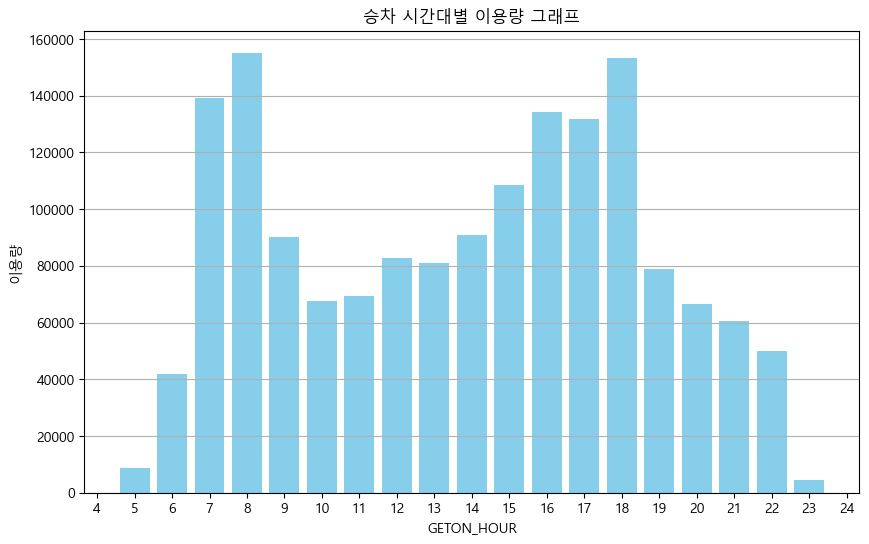

In [5]:
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator

# GETON_TIME별 이용량 계산
geton_time_counts = df['GETON_HOUR'].value_counts().sort_index()

# 그래프 그리기
plt.figure(figsize=(10, 6))
plt.bar(geton_time_counts.index, geton_time_counts.values, color='skyblue')
plt.xlabel('GETON_HOUR')
plt.ylabel('이용량')
plt.title('승차 시간대별 이용량 그래프')

# x축 눈금을 정수로 표시하기 위한 설정
plt.gca().xaxis.set_major_locator(MultipleLocator(base=1))

plt.xticks(rotation=0)
plt.grid(True, axis = 'y')
plt.show()


하차 시간대별 이용량 그래프

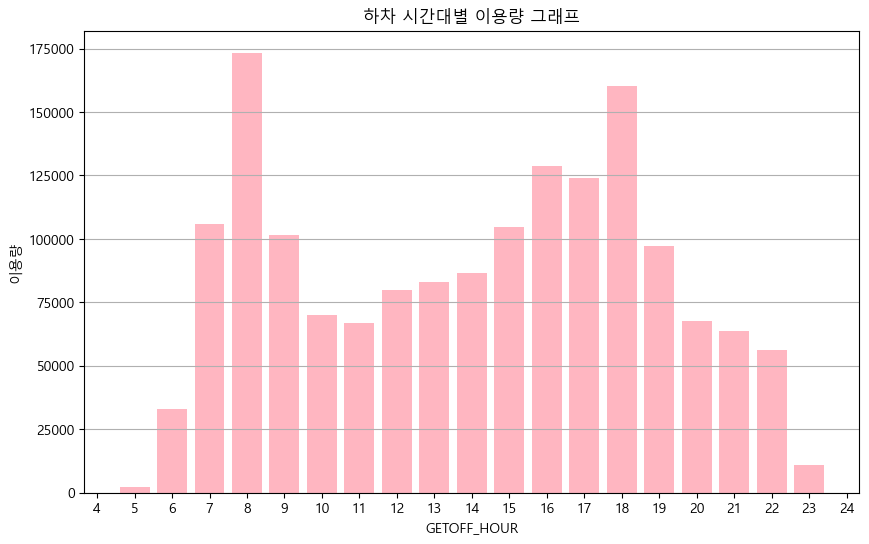

In [6]:
# GETOFF_TIME별 이용량 계산
getoff_time_counts = df['GETOFF_HOUR'].value_counts().sort_index()

# 그래프 그리기
plt.figure(figsize=(10, 6))
plt.bar(getoff_time_counts.index, getoff_time_counts.values, color='lightpink')
plt.xlabel('GETOFF_HOUR')
plt.ylabel('이용량')
plt.title('하차 시간대별 이용량 그래프')

# x축 눈금을 정수로 표시하기 위한 설정
plt.gca().xaxis.set_major_locator(MultipleLocator(base=1))

plt.xticks(rotation=0)
plt.grid(True, axis = 'y')
plt.show()

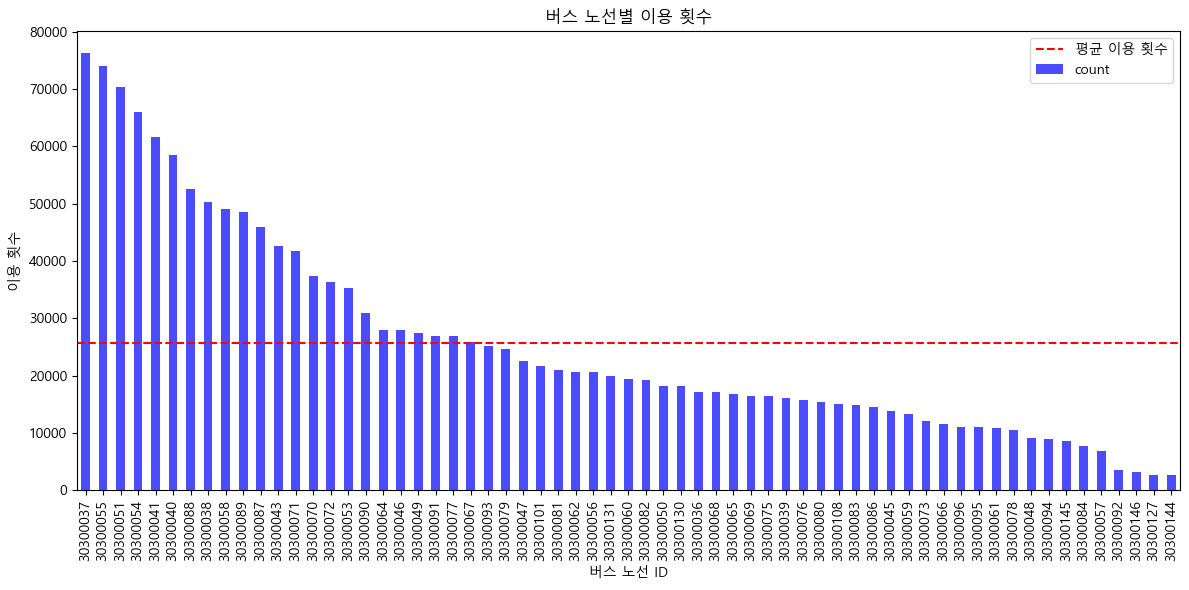

In [7]:
route_id = df['BUS_ROUTE_ID'].value_counts()

plt.figure(figsize=(12, 6))
route_id.plot(kind='bar', color='blue', alpha=0.7)
plt.axhline(y=df['BUS_ROUTE_ID'].value_counts().mean(), color='red', linestyle='--', label='평균 이용 횟수')
plt.xlabel('버스 노선 ID')
plt.ylabel('이용 횟수')
plt.title('버스 노선별 이용 횟수')
plt.xticks(rotation=90)
# 레전드 추가
plt.legend()
plt.tight_layout()
plt.show()

In [8]:
# 버스 노선별 이용 횟수 계산
route_counts = df['BUS_ROUTE_ID'].value_counts()

# 평균 이용 횟수 계산
mean_count = route_counts.mean()

# 평균 이용 횟수 이상의 데이터 필터링
filtered_routes = route_counts[route_counts >= mean_count]
filtered_routes = list(filtered_routes.index)

filtered_data = df[df['BUS_ROUTE_ID'].isin(filtered_routes)]
filtered_data.head(3)

,CARD_NO,TR_MEANS_TYPE,BUS_ROUTE_ID,BUS_CO_ID,BUS_CAR_ID,USR_TYPE,GETON_BUS_STTN_ID,GETOFF_BUS_STTN_ID,GETON_DATETIME,GETOFF_DATETIME,GETON_HOUR,GETOFF_HOUR
3,741520439,676,30300043,130010015,130759609,1,8001428,8002717,2022-04-01 07:32:15,2022-04-01 07:52:54,7,7
4,759623940,676,30300071,130010009,130759147,1,8001990,8001464,2022-04-01 19:10:41,2022-04-01 19:15:39,19,19
5,751746856,676,30300051,130010008,130752121,1,8002309,8002330,2022-04-01 20:25:05,2022-04-01 20:35:40,20,20


In [9]:
getrouteinfoall_df = getrouteinfoall[['ROUTE_CD','ROUTE_NO']]
filtered_data = filtered_data.merge(getrouteinfoall_df, left_on = 'BUS_ROUTE_ID', right_on = 'ROUTE_CD')
filtered_data = filtered_data[['CARD_NO', 'TR_MEANS_TYPE', 'BUS_ROUTE_ID', 'ROUTE_NO', 'BUS_CO_ID', 'BUS_CAR_ID','USR_TYPE', 'GETON_BUS_STTN_ID', 
                               'GETOFF_BUS_STTN_ID', 'GETON_DATETIME','GETOFF_DATETIME', 'GETON_HOUR', 'GETOFF_HOUR']]
filtered_data.head()

,CARD_NO,TR_MEANS_TYPE,BUS_ROUTE_ID,ROUTE_NO,BUS_CO_ID,BUS_CAR_ID,USR_TYPE,GETON_BUS_STTN_ID,GETOFF_BUS_STTN_ID,GETON_DATETIME,GETOFF_DATETIME,GETON_HOUR,GETOFF_HOUR
0,741520439,676,30300043,108,130010015,130759609,1,8001428,8002717,2022-04-01 07:32:15,2022-04-01 07:52:54,7,7
1,164744840,676,30300043,108,130010015,130759613,1,8001428,8001296,2022-04-01 10:03:56,2022-04-01 10:42:05,10,10
2,102451202,676,30300043,108,130010015,130759689,1,8002871,8001405,2022-04-01 07:37:18,2022-04-01 07:49:12,7,7
3,528605045,676,30300043,108,130010015,130759616,4,8001428,8005590,2022-04-01 07:52:41,2022-04-01 08:37:12,7,8
4,515469245,676,30300043,108,130010015,130759619,1,8005589,8001831,2022-04-01 13:08:13,2022-04-01 13:24:35,13,13


---

## 버스 승하차역 이용객수 TOP30 시각화

In [70]:
bus_station = df[['CARD_NO','BUS_CO_ID','BUS_CAR_ID','GETON_BUS_STTN_ID','GETOFF_BUS_STTN_ID']]
bus_station.head(3)

,CARD_NO,BUS_CO_ID,BUS_CAR_ID,GETON_BUS_STTN_ID,GETOFF_BUS_STTN_ID
1,540104832,130010001,130759426,8001279,8001538
3,741520439,130010015,130759609,8001428,8002717
4,759623940,130010009,130759147,8001990,8001464


In [71]:
bus_station['GETOFF_BUS_STTN_ID'] = bus_station['GETOFF_BUS_STTN_ID'].astype(int)
bus_station = bus_station.merge(bus_sttn, left_on = 'GETON_BUS_STTN_ID', right_on = 'bus_sttn_id')
bus_station = bus_station.merge(bus_sttn, left_on = 'GETOFF_BUS_STTN_ID', right_on = 'bus_sttn_id')
bus_station.drop(labels = ['bus_sttn_id_x', 'bus_sttn_id_y'], axis = 1, inplace = True)
bus_station.columns = ['CARD_NO','BUS_CO_ID','BUS_CAR_ID','GETON_BUS_STTN_ID','GETOFF_BUS_STTN_ID','GETON_BUS_STTN_NM','GETON_POSX','GETON_POSY','GETOFF_BUS_STTN_NM','GETOFF_POSX','GETOFF_POSY']
bus_station = bus_station[['CARD_NO','BUS_CO_ID','BUS_CAR_ID','GETON_BUS_STTN_ID','GETON_BUS_STTN_NM','GETON_POSX','GETON_POSY','GETOFF_BUS_STTN_ID','GETOFF_BUS_STTN_NM','GETOFF_POSX','GETOFF_POSY']]
bus_station.head()

,CARD_NO,BUS_CO_ID,BUS_CAR_ID,GETON_BUS_STTN_ID,GETON_BUS_STTN_NM,GETON_POSX,GETON_POSY,GETOFF_BUS_STTN_ID,GETOFF_BUS_STTN_NM,GETOFF_POSX,GETOFF_POSY
0,540104832,130010001,130759426,8001279,구농도원네거리,36.317562,127.37806,8001538,동산중고등학교,36.314426,127.40493
1,545432869,130010001,130759775,8001279,구농도원네거리,36.317562,127.37806,8001538,동산중고등학교,36.314426,127.40493
2,519901331,130010001,130759710,8001279,구농도원네거리,36.317562,127.37806,8001538,동산중고등학교,36.314426,127.40493
3,592551145,130010001,130759789,8001279,구농도원네거리,36.317562,127.37806,8001538,동산중고등학교,36.314426,127.40493
4,543573212,130010001,130759710,8001279,구농도원네거리,36.317562,127.37806,8001538,동산중고등학교,36.314426,127.40493


In [79]:
### 버스 승차역 이용객수 TOP30
bus_station_geton = list(bus_station['GETON_BUS_STTN_ID'].value_counts().head(20).index)
bus_station_geton_top20 = bus_station[bus_station['GETON_BUS_STTN_ID'].isin(bus_station_geton)]
bus_station_geton_top20 = bus_station_geton_top20[['GETON_BUS_STTN_ID','GETON_BUS_STTN_NM','GETON_POSX','GETON_POSY']]
bus_station_geton_top20.drop_duplicates(inplace = True)
bus_station_geton_top20.head(3)

,GETON_BUS_STTN_ID,GETON_BUS_STTN_NM,GETON_POSX,GETON_POSY
1073,8001587,롯데백화점,36.340076,127.39074
2443,8001078,갤러리아타임월드,36.352608,127.37894
2544,8002721,충남대학교,36.361560,127.34411


In [84]:
bus_station['GETOFF_BUS_STTN_NM'].value_counts().head(20).index

Index(['복합터미널', '대전역', '은하수네거리', '으능정이거리', '충남대학교', '시청역', '갤러리아타임월드',
       '유성온천역7번출구', '대전역/역전시장', '서구보건소', '파랑새네거리', '서대전역네거리', '관평중학교', '목척교',
       '가수원육교.가수원시장', '대전보건대학', '한남대학교', '온천교', '용문역5번출구', '정부청사역'],
      dtype='object', name='GETOFF_BUS_STTN_NM')

In [80]:
### 버스 하차역 이용객수 TOP30
bus_station_getoff = list(bus_station['GETOFF_BUS_STTN_ID'].value_counts().head(20).index)
bus_station_getoff_top20 = bus_station[bus_station['GETOFF_BUS_STTN_ID'].isin(bus_station_getoff)]
bus_station_getoff_top20 = bus_station_getoff_top20[['GETOFF_BUS_STTN_ID','GETOFF_BUS_STTN_NM','GETOFF_POSX','GETOFF_POSY']]
bus_station_getoff_top20.drop_duplicates(inplace = True)
bus_station_getoff_top20.head(3)

,GETOFF_BUS_STTN_ID,GETOFF_BUS_STTN_NM,GETOFF_POSX,GETOFF_POSY
2097,8001028,가수원육교.가수원시장,36.304690,127.350845
41715,8001934,서대전역네거리,36.320564,127.406425
175494,8001420,대전역,36.333435,127.431410


In [120]:
import pydeck as pdk
import pandas as pd

# 데이터프레임에서 GETON_BUS_STTN_ID에 해당하는 데이터만 추출

# ScatterplotLayer 데이터 생성
geton_layer = pdk.Layer(
    "ScatterplotLayer",
    data=bus_station_geton_top20,
    get_position=["GETON_POSY", "GETON_POSX"],
    get_radius=80,
    get_color=[255, 0, 0, 150],  # 빨간색 (RGB 및 투명도)
    pickable=True,
    
)

getoff_layer = pdk.Layer(
    "ScatterplotLayer",
    data=bus_station_getoff_top20,
    get_position=["GETOFF_POSY", "GETOFF_POSX"],
    get_radius=80,
    get_color=[0, 0, 255, 150],  # 빨간색 (RGB 및 투명도)
    pickable=True,
    
)

# PyDeck 맵 생성
view_state = pdk.ViewState(latitude=36.35, longitude=127.37, zoom=11)
deck = pdk.Deck(layers=[geton_layer,getoff_layer], initial_view_state=view_state)
# deck.to_html("TOP20_bus_station.html")  # 지도를 HTML 파일로 저장
# deck

## 상위 이용 정류장 지나는 노선들

In [130]:
yellow_geton = [8002814,8001078,8006006,8002453,8002757,8002088,8002969]
yellow_getoff = [8002468,8002814,8001078,8002453,8002969]
pink_geton = [8001418,8002437,8002635]
pink_getoff = [8001420,8001419,8001418,8002454,8001412]

route_id = [30300037,30300055,30300051,30300054,30300041,30300040,30300088,30300038,30300058,
30300089,30300087,30300043,30300071,30300070,30300072,30300053,30300090,30300064, 30300046,30300049,30300091,30300077,30300067]

getrouteinfoall_df = getrouteinfoall[['ROUTE_CD','ROUTE_NO']]

In [131]:
df_yellow_geton = df[df['GETON_BUS_STTN_ID'].isin(yellow_geton)]
df_yellow_geton_route = df_yellow_geton[df_yellow_geton['BUS_ROUTE_ID'].isin(route_id)]
df_yellow_geton_route.head(3)

,CARD_NO,TR_MEANS_TYPE,BUS_ROUTE_ID,BUS_CO_ID,BUS_CAR_ID,USR_TYPE,GETON_BUS_STTN_ID,GETOFF_BUS_STTN_ID,GETON_DATETIME,GETOFF_DATETIME,GETON_HOUR,GETOFF_HOUR
83,543986076,676,30300071,130010009,130759150,1,8001078,8001464,2022-04-01 19:04:43,2022-04-01 19:32:06,19,19
714,533197507,676,30300054,130010007,130759387,4,8002453,8001923,2022-04-01 19:41:45,2022-04-01 19:50:43,19,19
913,789379261,676,30300071,130010009,130759144,1,8001078,8001464,2022-04-01 08:00:27,2022-04-01 08:25:25,8,8


In [144]:
df_yellow_geton_route_merge = df_yellow_geton_route.merge(getrouteinfoall_df, left_on = 'BUS_ROUTE_ID', right_on = 'ROUTE_CD')
df_yellow_geton_route_merge = df_yellow_geton_route_merge[['CARD_NO', 'TR_MEANS_TYPE', 'BUS_ROUTE_ID', 'ROUTE_NO', 'BUS_CO_ID', 'BUS_CAR_ID','USR_TYPE', 'GETON_BUS_STTN_ID', 
                               'GETOFF_BUS_STTN_ID', 'GETON_DATETIME','GETOFF_DATETIME', 'GETON_HOUR', 'GETOFF_HOUR']]
df_yellow_geton_route_merge = df_yellow_geton_route_merge[['BUS_ROUTE_ID','ROUTE_NO','GETON_BUS_STTN_ID','GETOFF_BUS_STTN_ID']]
df_yellow_geton_route_merge.head()

,BUS_ROUTE_ID,ROUTE_NO,GETON_BUS_STTN_ID,GETOFF_BUS_STTN_ID
0,30300071,604,8001078,8001464
1,30300071,604,8001078,8001464
2,30300071,604,8002814,8002901
3,30300071,604,8002757,8002570
4,30300071,604,8001078,8002758


In [183]:
def station_route_merge(getstationbyrouteall,route_cd):
    exdata = getstationbyrouteall[getstationbyrouteall['ROUTE_CD']==route_cd].reset_index()
    index_condition = exdata[exdata['BUSSTOP_TP'] == '2'].index.max() -1
    exdata = exdata.iloc[:index_condition]
    return exdata

In [188]:
route_703 = station_route_merge(getstationbyrouteall, 30300087)
route_301 = station_route_merge(getstationbyrouteall, 30300054)
route_604 = station_route_merge(getstationbyrouteall, 30300071)
route_705 = station_route_merge(getstationbyrouteall, 30300089)
route_106 = station_route_merge(getstationbyrouteall, 30300041)
route_605 = station_route_merge(getstationbyrouteall, 30300072)
route_706 = station_route_merge(getstationbyrouteall, 30300090)
route_211 = station_route_merge(getstationbyrouteall, 30300053)
route_105 = station_route_merge(getstationbyrouteall, 30300040)

In [193]:
import pydeck as pdk

# 데이터프레임을 기반으로 pydeck Layer를 생성합니다
layer_703 = pdk.Layer(
    "ScatterplotLayer",
    data=route_703,  # 시각화할 데이터프레임
    get_position=["GPS_LONG", "GPS_LATI"],  # 경도와 위도를 지정
    get_radius=100,  # 포인트 반경 크기
    get_fill_color=[255, 0, 0],  # 포인트 색상 (RGB 값)
    pickable=True, 
)

layer_301 = pdk.Layer(
    "ScatterplotLayer",
    data=route_301,  # 시각화할 데이터프레임
    get_position=["GPS_LONG", "GPS_LATI"],  # 경도와 위도를 지정
    get_radius=100,  # 포인트 반경 크기
    get_fill_color=[255, 150, 0],  # 주황색
    pickable=True, 
)

layer_604 = pdk.Layer(
    "ScatterplotLayer",
    data=route_604,  # 시각화할 데이터프레임
    get_position=["GPS_LONG", "GPS_LATI"],  # 경도와 위도를 지정
    get_radius=100,  # 포인트 반경 크기
    get_fill_color=[255,200, 0],  # 노란색
    pickable=True, 
)

layer_705 = pdk.Layer(
    "ScatterplotLayer",
    data=route_705,  # 시각화할 데이터프레임
    get_position=["GPS_LONG", "GPS_LATI"],  # 경도와 위도를 지정
    get_radius=100,  # 포인트 반경 크기
    get_fill_color=[0, 100, 50],   # 초록색
    pickable=True, 
)

layer_106 = pdk.Layer(
    "ScatterplotLayer",
    data=route_106,  # 시각화할 데이터프레임
    get_position=["GPS_LONG", "GPS_LATI"],  # 경도와 위도를 지정
    get_radius=100,  # 포인트 반경 크기
    get_fill_color=[0, 50, 200],  # 파란색
    pickable=True, 
)

layer_605 = pdk.Layer(
    "ScatterplotLayer",
    data=route_605,  # 시각화할 데이터프레임
    get_position=["GPS_LONG", "GPS_LATI"],  # 경도와 위도를 지정
    get_radius=100,  # 포인트 반경 크기
    get_fill_color=[100, 0, 150],  # 보라색
    pickable=True, 
)

layer_706 = pdk.Layer(
    "ScatterplotLayer",
    data=route_706,  # 시각화할 데이터프레임
    get_position=["GPS_LONG", "GPS_LATI"],  # 경도와 위도를 지정
    get_radius=100,  # 포인트 반경 크기
    get_fill_color=[150, 50, 0],  # 똥색
    pickable=True, 
)

layer_211 = pdk.Layer(
    "ScatterplotLayer",
    data=route_211,  # 시각화할 데이터프레임
    get_position=["GPS_LONG", "GPS_LATI"],  # 경도와 위도를 지정
    get_radius=100,  # 포인트 반경 크기
    get_fill_color=[50, 50, 0],  # 똥색
    pickable=True, 
)

layer_105 = pdk.Layer(
    "ScatterplotLayer",
    data=route_105,  # 시각화할 데이터프레임
    get_position=["GPS_LONG", "GPS_LATI"],  # 경도와 위도를 지정
    get_radius=100,  # 포인트 반경 크기
    get_fill_color=[150, 150, 0],  # 회색
    pickable=True, 
)

# pydeck Deck을 생성하고 Layer를 추가합니다
view_state = pdk.ViewState(
    longitude=127.41,  # 중심 경도
    latitude=36.45,    # 중심 위도
    zoom=11,           # 줌 레벨
    pitch=0,          # 카메라 기울기
)

r = pdk.Deck(layers=[layer_703,layer_301,layer_604,layer_705,layer_106,layer_605,layer_706,layer_211,layer_105], initial_view_state=view_state)

# pydeck Deck을 시각화합니다
# r.to_html("pydeck_route_703.html")  # HTML 파일로 저장


## 노선 평균 속도

In [243]:
getstationbyrouteall_route = getstationbyrouteall[['BUSSTOP_NM','BUSSTOP_SEQ','BUSSTOP_TP','BUS_NODE_ID','ROUTE_CD','TOTAL_DIST']]
getstationbyrouteall_route.head()

,BUSSTOP_NM,BUSSTOP_SEQ,BUSSTOP_TP,BUS_NODE_ID,ROUTE_CD,TOTAL_DIST
0,충대농대종점,1,1,8002736,30300001,51
1,한빛아파트,2,,8002941,30300001,434
2,충대농대입구,3,,8002735,30300001,815
3,궁동,4,,8001193,30300001,1090
4,충남대학교,5,,8002721,30300001,1667


In [244]:
# 102번 노선
route_102 = df[df['BUS_ROUTE_ID']==30300037]
route_102 = route_102[['BUS_ROUTE_ID','GETON_BUS_STTN_ID','GETON_DATETIME','GETOFF_BUS_STTN_ID','GETOFF_DATETIME']]
route_102.head()

,BUS_ROUTE_ID,GETON_BUS_STTN_ID,GETON_DATETIME,GETOFF_BUS_STTN_ID,GETOFF_DATETIME,TRAVEL_TIME
363,30300037,8002340,2022-04-01 11:42:45,8002312,2022-04-01 11:54:07,0 days 00:11:22
686,30300037,8002898,2022-04-01 11:34:17,8002312,2022-04-01 11:42:23,0 days 00:08:06
741,30300037,8001443,2022-04-01 06:28:35,8001534,2022-04-01 06:34:29,0 days 00:05:54
840,30300037,8001037,2022-04-01 08:25:15,8001348,2022-04-01 08:33:44,0 days 00:08:29
950,30300037,8002402,2022-04-01 07:49:49,8001912,2022-04-01 08:08:45,0 days 00:18:56


In [245]:
getstationbyrouteall_route_102 = getstationbyrouteall_route[getstationbyrouteall_route['ROUTE_CD']==30300037]
getstationbyrouteall_route_102.head(2)

,BUSSTOP_NM,BUSSTOP_SEQ,BUSSTOP_TP,BUS_NODE_ID,ROUTE_CD,TOTAL_DIST
2189,수통골기점지,1,1,8002077,30300037,36
2190,수통골삼거리,2,,8003003,30300037,332


In [270]:
route_102_merge = route_102.merge(getstationbyrouteall_route_102, left_on = 'GETON_BUS_STTN_ID', right_on = 'BUS_NODE_ID')
route_102_merge = route_102_merge[['BUS_ROUTE_ID','GETON_BUS_STTN_ID','GETON_DATETIME','TOTAL_DIST','GETOFF_BUS_STTN_ID','GETOFF_DATETIME']]
route_102_merge.columns = ['BUS_ROUTE_ID','GETON_BUS_STTN_ID','GETON_DATETIME','GETON_TOTAL_DIST','GETOFF_BUS_STTN_ID','GETOFF_DATETIME']
route_102_merge = route_102_merge.merge(getstationbyrouteall_route_102, left_on = 'GETOFF_BUS_STTN_ID', right_on = 'BUS_NODE_ID')
route_102_merge = route_102_merge[['BUS_ROUTE_ID','GETON_BUS_STTN_ID','GETON_DATETIME','GETON_TOTAL_DIST','GETOFF_BUS_STTN_ID','GETOFF_DATETIME','TOTAL_DIST']]
route_102_merge.columns = ['BUS_ROUTE_ID','GETON_BUS_STTN_ID','GETON_DATETIME','GETON_TOTAL_DIST','GETOFF_BUS_STTN_ID','GETOFF_DATETIME','GETOFF_TOTAL_DIST']
route_102_merge['TRAVEL_TIME'] = route_102_merge['GETOFF_DATETIME'] - route_102_merge['GETON_DATETIME']
route_102_merge.head()

,BUS_ROUTE_ID,GETON_BUS_STTN_ID,GETON_DATETIME,GETON_TOTAL_DIST,GETOFF_BUS_STTN_ID,GETOFF_DATETIME,GETOFF_TOTAL_DIST,TRAVEL_TIME
0,30300037,8002340,2022-04-01 11:42:45,24168,8002312,2022-04-01 11:54:07,27862,0 days 00:11:22
1,30300037,8002340,2022-04-05 14:59:09,24168,8002312,2022-04-05 15:13:17,27862,0 days 00:14:08
2,30300037,8002340,2022-04-25 20:27:13,24168,8002312,2022-04-25 20:40:03,27862,0 days 00:12:50
3,30300037,8002340,2022-04-12 20:48:57,24168,8002312,2022-04-12 21:01:45,27862,0 days 00:12:48
4,30300037,8002340,2022-04-20 19:36:39,24168,8002312,2022-04-20 19:48:35,27862,0 days 00:11:56


In [271]:
route_102_merge['GETON_TOTAL_DIST'] = route_102_merge['GETON_TOTAL_DIST'].astype(float)
route_102_merge['GETOFF_TOTAL_DIST'] = route_102_merge['GETOFF_TOTAL_DIST'].astype(float)

# TRAVEL_TIME 시간 단위로 변환 후 계산
route_102_merge['TRAVEL_TIME_HOURS'] = route_102_merge['TRAVEL_TIME'].dt.total_seconds() / 3600

route_102_merge['TRAVEL_SPEED'] = abs((route_102_merge['GETOFF_TOTAL_DIST']/1000 - route_102_merge['GETON_TOTAL_DIST']/1000) / route_102_merge['TRAVEL_TIME_HOURS'])

In [274]:
# 0인 경우 제외
route_102_merge = route_102_merge[route_102_merge['TRAVEL_SPEED']!=0.000000]

# 70이상 제외
route_102_merge = route_102_merge[route_102_merge['TRAVEL_SPEED']<=70]

In [275]:
route_102_merge.sort_values('TRAVEL_SPEED')

,BUS_ROUTE_ID,GETON_BUS_STTN_ID,GETON_DATETIME,GETON_TOTAL_DIST,GETOFF_BUS_STTN_ID,GETOFF_DATETIME,GETOFF_TOTAL_DIST,TRAVEL_TIME,TRAVEL_TIME_HOURS,TRAVEL_SPEED
40299,30300037,8002340,2022-04-20 18:36:02,24168.0,8002339,2022-04-20 21:26:35,18388.0,0 days 02:50:33,2.842500,2.033421
37009,30300037,8002344,2022-04-13 14:51:22,23801.0,8001097,2022-04-13 17:49:53,16216.0,0 days 02:58:31,2.975278,2.549342
37008,30300037,8002344,2022-04-13 14:51:26,23801.0,8001097,2022-04-13 17:49:55,16216.0,0 days 02:58:29,2.974722,2.549818
8129,30300037,8002343,2022-04-11 06:01:46,24637.0,8001443,2022-04-11 06:08:44,24948.0,0 days 00:06:58,0.116111,2.678469
36016,30300037,8002340,2022-04-20 18:36:04,24168.0,8001097,2022-04-20 21:19:48,16216.0,0 days 02:43:44,2.728889,2.914007
...,...,...,...,...,...,...,...,...,...,...
47562,30300037,8002345,2022-04-28 12:54:22,18772.0,8002488,2022-04-28 12:54:43,19164.0,0 days 00:00:21,0.005833,67.200000
5012,30300037,8001574,2022-04-22 07:42:21,32043.0,8002558,2022-04-22 07:43:05,32865.0,0 days 00:00:44,0.012222,67.254545
11713,30300037,8002658,2022-04-01 10:18:04,28988.0,8002100,2022-04-01 10:19:03,30109.0,0 days 00:00:59,0.016389,68.400000
76259,30300037,8005504,2022-04-21 19:25:30,21410.0,9005504,2022-04-21 19:25:40,21600.0,0 days 00:00:10,0.002778,68.400000
